In [2]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import cmocean
import matplotlib
import matplotlib.pyplot as plt

# from matplotlib import gridspec
# from matplotlib.gridspec import GridSpec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# import matplotlib.ticker as mticker
# import cartopy.mpl.ticker as cticker
# from cartopy.util import add_cyclic_point as cyclic
import cftime
# import nc_time_axis
import datetime

import xesmf as xe

# # import time
# # import glob, os
# # import math
# import copy

# from sklearn.metrics import r2_score
# import scipy.interpolate as scp
# from scipy.stats import skew
# from scipy.ndimage.filters import gaussian_filter

# import eofs
# from eofs.xarray import Eof

%load_ext autoreload
%autoreload 2

In [3]:
from defs import change_lons, change_lons2

In [4]:
length = 1200; start_date = '31/1/2001';
time = pd.date_range(start = start_date, periods=length, freq='M')
dummy_time=xr.Dataset({"time": time})

In [5]:
folder_anom = 'PlioMIP2 SST data/models/'
folder_clim = 'PlioMIP2 SST data/climatology/'

slp_modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 
             'CESM2', 'COSMOS', 'EC-Earth3-LR', 'GISS2.1G',
             'HadCM3', 'HadGEM3', 'IPSL-CM5A', 'IPSL-CM5A2',
             'IPSL-CM6A', 'MIROC4m', 'MRI-GCGM2.3',
             'NorESM-L', 'NorESM1-F']

modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 
             'CESM2', 'COSMOS', 'EC-Earth3.3', 'GISS2.1G',
             'HadCM3', 'HadGEM3', 'IPSLCM5A', 'IPSLCM5A2',
             'IPSLCM6A', 'MIROC4m', 'MRI2.3',
             'NorESM-L', 'NorESM1-F']

sim_e280   = 'E280'
sim_eoi400 = 'EOI400'

In [4]:


#anomaly name:     filename = folder_anom + model + '/' + model + '_' + simulation + '.SST.timeseries_no_ann_cycle.nc'
#climatology name: filename = folder_clim + model + '/' + simulation + '.SST.mean_month.nc'


# CCSM4
# TS --> sst
# latitude --> lat; longitude --> lon
# starts in: jan

# CCSM4-UoT
# tos --> sst
# starts in: jan

# CCSM4-Utr 
#### !!!!!!!!!!!!!!!!!!! ####
## E280 data from Globus!
## Eoi400: SST data from Globus, SLP from Snellius (but its the same)
# tos --> sst
# latitude --> lat; longitude --> lon
# starts in: jan

# CESM1.2
# TS --> sst
# latitude --> lat; longitude --> lon
# starts in: jan

# CESM2
# TS --> sst
# latitude --> lat; longitude --> lon
# starts in: jan
# note: 1212 months 

# COSMOS
# tos --> sst
# latitude --> lat; longitude --> lon
# starts in: jan

# EC-Earth3-LR
# latitude --> lat; longitude --> lon
# starts in: jan

# GISS2.1G
# tos --> sst
# latitude --> lat; longitude --> lon
# starts in: jan

# HadCM3
# temp --> sst
# latitude --> lat; longitude --> lon
# starts in: jan
#time_origin :01-SEP-2899:00:00:00 ??????????
# (may start in dec?)

# HadGEM3
# tos --> sst
# time_counter --> time
# latitude --> lat; longitude --> lon
# starts in: jan

# IPSL-CM5A
# time_counter --> time
# latitude --> lat; longitude --> lon
# starts in: jan

# IPSL-CM5A2
# time_counter --> time
# latitude --> lat; longitude --> lon
# starts in: jan

# IPSL-CM6A
# tos --> sst
# latitude --> lat; longitude --> lon
# starts in: jan

# MIROC4m
# tos --> sst
# latitude --> lat; longitude --> lon
# starts in: jan

# MRI-GCGM2.3
# tos --> sst
# latitude --> lat; longitude --> lon
# starts in: jan
# (may start in dec?)

# NorESM-L
# latitude --> lat; longitude --> lon
# starts in: jan

# NorESM1-F
# latitude --> lat; longitude --> lon
# starts in: jan

# some defs

In [6]:
def renaming(ds, model, anom):

    # rename lat, lon
    if model != 'CCSM4-UoT':
        ds = ds.rename({'latitude':'lat'}).rename({'longitude':'lon'});

    # rename sst
    if model == 'CCSM4' or model == 'CESM1.2' or model == 'CESM2':
        ds = ds.rename({'TS':'sst'});
    elif model == 'CCSM4-UoT' or model == 'CCSM4-Utr' or model == 'COSMOS' or model == 'GISS2.1G' or model == 'HadGEM3' or model == 'IPSLCM6A' or model == 'MIROC4m' or model == 'MRI2.3':
        ds = ds.rename({'tos':'sst'});
    elif model == 'HadCM3':
        ds = ds.rename({'temp':'sst'});

    # rename time
    if anom == "anom":
        if model == 'IPSLCM5A' or model == 'IPSLCM5A2' or model == 'HadGEM3':  
            ds = ds.rename({'time_counter':'time'})
#     assert 'time' in ds.dims  

    if model == 'CESM2' and anom == "anom":
        ds = ds.isel(time = slice(0,1200));
    
    return ds

In [7]:
def flatten_climatology(ds, nyears):

    clim = ds.sst

    if model == 'HadGEM3' or model == 'NorESM-L' or model == 'NorESM1-F':  
        clim = clim.rename({'time':'month'})

    clim_ = clim
    for i in range(1,nyears):
        clim_ = xr.concat([clim_, clim], dim='dummy');

    clim_array = clim_.stack(time_new=("dummy", "month"))
    clims = xr.DataArray(data = clim_array,
                 dims = ["lat", "lon", "time"],
                 coords = dict(time = dummy_time.time,
                               lat  = ds.lat,
                               lon  = ds.lon))
    
    return clims

## CCSM4-Utrecht E280 regridding

In [5]:
import xesmf as xe

# original CESM Utrecht SST data from Snellius
# path = 'PlioMIP2 data/CCSM4-Utr/E280/E280p_SST_6401_6500.nc'
# ds = xr.open_dataset(path, decode_times=False)

# # regridded and renamed ref data
# ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
# ds_ref = xr.open_dataset(ref_path, decode_times=False)

# # select ssts
# # sst = ds.tos.where(ds.tos<100).isel(z_t=0).isel(time=slice(0,1200))
# # sst = sst.rename({'TLONG':'lon'}).rename({'TLAT':'lat'})
# sst = ds#.isel(time=slice(0,1200))

# # make regridder to 1x1 grid
# regridder = xe.Regridder(sst, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)

# sst_reg = regridder(sst.tos.where(sst.tos<100))
# # sst_reg = sst_reg.drop("z_t").to_dataset(name="sst")
# sst_reg = sst_reg.to_dataset(name="sst")
# sst_reg["time"] = dummy_time.time
# sst_reg.sst.attrs['units'] = 'deg C'
# sst_reg.sst.attrs['description'] = 'SSTs'
# sst_reg.attrs['model'] = 'CCSM4-Utr'
# sst_reg.attrs['sim'] = 'E280'

# sst_reg.to_netcdf('PlioMIP2 data/CCSM4-Utr/E280/E280_sst_monthly.nc', mode = 'w')


# Eoi280

# original CESM Utrecht SST data from Snellius
path = 'PlioMIP2 data/CCSM4-Utr/Eoi280/Eoi280_SST_2801_3000.nc'
ds = xr.open_dataset(path, decode_times=False)

# regridded and renamed ref data
ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)

# select ssts
# sst = ds.tos.where(ds.tos<100).isel(z_t=0).isel(time=slice(0,1200))
# sst = sst.rename({'TLONG':'lon'}).rename({'TLAT':'lat'})
sst = ds.isel(time=slice(0,1200))

# make regridder to 1x1 grid
regridder = xe.Regridder(sst, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)

sst_reg = regridder(sst.tos.where(sst.tos<100))
# sst_reg = sst_reg.drop("z_t").to_dataset(name="sst")
sst_reg = sst_reg.to_dataset(name="sst")
sst_reg["time"] = dummy_time.time
sst_reg.sst.attrs['units'] = 'deg C'
sst_reg.sst.attrs['description'] = 'SSTs'
sst_reg.attrs['model'] = 'CCSM4-Utr'
sst_reg.attrs['sim'] = 'Eoi280'

sst_reg.to_netcdf('PlioMIP2 data/CCSM4-Utr/Eoi280/Eoi280_sst_monthly.nc', mode = 'w')

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## CCSM4_UoT E400

In [10]:
import xesmf as xe

# E400

# 
path = 'PlioMIP2 SST data/models/CCSM4-UoT/tos_Omon_UofT-CCSM4_PlioMIP2-E400_r1i1p1f1_gn_150101-160012.nc'
ds = xr.open_dataset(path, decode_times=False)

# regridded and renamed ref data
ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)

# select ssts
# sst = ds.tos.where(ds.tos<100).isel(z_t=0).isel(time=slice(0,1200))
# sst = sst.rename({'TLONG':'lon'}).rename({'TLAT':'lat'})
sst = ds#.isel(time=slice(0,1200))

# make regridder to 1x1 grid
regridder = xe.Regridder(sst, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)

sst_reg = regridder(sst.tos.where(sst.tos<100))
# sst_reg = sst_reg.drop("z_t").to_dataset(name="sst")
sst_reg = sst_reg.to_dataset(name="sst")
sst_reg["time"] = dummy_time.time
sst_reg.sst.attrs['units'] = 'deg C'
sst_reg.sst.attrs['description'] = 'SSTs'
sst_reg.attrs['model'] = 'CCSM4-UoT'
sst_reg.attrs['sim'] = 'E400'

sst_reg.to_netcdf('PlioMIP2 data/CCSM4-UoT/E400/E400_sst_monthly.nc', mode = 'w')

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## COSMOS Eoi280

In [6]:
import xesmf as xe

# Eoi280

# 
path = 'PlioMIP2 SST data/models/COSMOS/Eoi280.SeaSurfaceTemp_CMIP6_name_tos_2650-2749_monthly_mean_time_series_remapbil.nc'
ds = xr.open_dataset(path, decode_times=False)

# regridded and renamed ref data
ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)

# select ssts
# sst = ds.tos.where(ds.tos<100).isel(z_t=0).isel(time=slice(0,1200))
# sst = sst.rename({'TLONG':'lon'}).rename({'TLAT':'lat'})
sst = ds#.isel(time=slice(0,1200))

# make regridder to 1x1 grid
regridder = xe.Regridder(sst, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)

sst_reg = regridder(sst.tos.where(sst.tos<100))
# sst_reg = sst_reg.drop("z_t").to_dataset(name="sst")
sst_reg = sst_reg.to_dataset(name="sst")
sst_reg["time"] = dummy_time.time
sst_reg.sst.attrs['units'] = 'deg C'
sst_reg.sst.attrs['description'] = 'SSTs'
sst_reg.attrs['model'] = 'COSMOS'
sst_reg.attrs['sim'] = 'Eoi280'

sst_reg.to_netcdf('PlioMIP2 data/COSMOS/Eoi280/Eoi280_sst_monthly.nc', mode = 'w')

In [8]:
import xesmf as xe

# E400

# 
path = 'PlioMIP2 SST data/models/COSMOS/E400.SeaSurfaceTemp_CMIP6_name_tos_2650-2749_monthly_mean_time_series_remapbil.nc'
ds = xr.open_dataset(path, decode_times=False)

# regridded and renamed ref data
ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)

# select ssts
# sst = ds.tos.where(ds.tos<100).isel(z_t=0).isel(time=slice(0,1200))
# sst = sst.rename({'TLONG':'lon'}).rename({'TLAT':'lat'})
sst = ds#.isel(time=slice(0,1200))

# make regridder to 1x1 grid
regridder = xe.Regridder(sst, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)

sst_reg = regridder(sst.tos.where(sst.tos<100))
# sst_reg = sst_reg.drop("z_t").to_dataset(name="sst")
sst_reg = sst_reg.to_dataset(name="sst")
sst_reg["time"] = dummy_time.time
sst_reg.sst.attrs['units'] = 'deg C'
sst_reg.sst.attrs['description'] = 'SSTs'
sst_reg.attrs['model'] = 'COSMOS'
sst_reg.attrs['sim'] = 'E400'

sst_reg.to_netcdf('PlioMIP2 data/COSMOS/E400/E400_sst_monthly.nc', mode = 'w')

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## HadCM3 E280_corr regridding

In [155]:
folder = 'PlioMIP2 SST data/models/HadCM3/E280_corr/'
# folder = 'PlioMIP2 SST data/models/HadCM3/E280/'


# get all files

file = 'e280_corr.SST.0'
file0 = 'e280_corr.SST.000.nc'

# file = 'e280.SST.0'
# file0 = 'e280.SST.000.nc'
ds = xr.open_dataset(folder+file0, decode_times=False).temp.isel(unspecified=0)

ylen = 100
for yi in range(1,ylen):

    if yi<10: years = f'0{yi}.nc';
    else:     years = f'{yi}.nc';
    
    ds_ = xr.open_dataset(folder+file+years, decode_times=False).temp.isel(unspecified=0)
    
    ds = xr.concat([ds, ds_], dim="t")

ds=ds.rename({"latitude":"lat"}).rename({"longitude":"lon"}).sortby("lat")
ds = ds.drop("unspecified").rename({"t":"time"})

import xesmf as xe

ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)

regridder = xe.Regridder(ds, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)

sst = regridder(ds)

sst = sst.to_dataset(name="sst")
sst["time"] = dummy_time.time
sst.sst.attrs['units'] = 'deg C'
sst.sst.attrs['description'] = 'SSTs'
sst.attrs['model'] = 'HadCM3'
sst.attrs['sim'] = 'E280'

sst.to_netcdf('PlioMIP2 data/HadCM3/E280/E280_sst_monthly.nc', mode = 'w')

In [8]:
folder = 'PlioMIP2 SST data/models/HadCM3/Eoi280/'

# get all files

file = 'eoi280.SST.0'
file0 = 'eoi280.SST.000.nc'

ds = xr.open_dataset(folder+file0, decode_times=False).temp.isel(unspecified=0)

ylen = 100
for yi in range(1,ylen):

    if yi<10: years = f'0{yi}.nc';
    else:     years = f'{yi}.nc';
    
    ds_ = xr.open_dataset(folder+file+years, decode_times=False).temp.isel(unspecified=0)
    
    ds = xr.concat([ds, ds_], dim="t")

ds=ds.rename({"latitude":"lat"}).rename({"longitude":"lon"}).sortby("lat")
ds = ds.drop("unspecified").rename({"t":"time"})

import xesmf as xe

ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)

regridder = xe.Regridder(ds, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)

sst = regridder(ds)

sst = sst.to_dataset(name="sst")
sst["time"] = dummy_time.time
sst.sst.attrs['units'] = 'deg C'
sst.sst.attrs['description'] = 'SSTs'
sst.attrs['model'] = 'HadCM3'
sst.attrs['sim'] = 'Eoi280'

sst.to_netcdf('PlioMIP2 data/HadCM3/Eoi280/Eoi280_sst_monthly.nc', mode = 'w')

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/dataarray.py:679: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/smm.py:93: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [9]:
folder = 'PlioMIP2 SST data/models/HadCM3/E400/'

# get all files

file = 'e400.SST.0'
file0 = 'e400.SST.000.nc'

ds = xr.open_dataset(folder+file0, decode_times=False).temp.isel(unspecified=0)

ylen = 100
for yi in range(1,ylen):

    if yi<10: years = f'0{yi}.nc';
    else:     years = f'{yi}.nc';
    
    ds_ = xr.open_dataset(folder+file+years, decode_times=False).temp.isel(unspecified=0)
    
    ds = xr.concat([ds, ds_], dim="t")

ds=ds.rename({"latitude":"lat"}).rename({"longitude":"lon"}).sortby("lat")
ds = ds.drop("unspecified").rename({"t":"time"})

import xesmf as xe

ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)

regridder = xe.Regridder(ds, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)

sst = regridder(ds)

sst = sst.to_dataset(name="sst")
sst["time"] = dummy_time.time
sst.sst.attrs['units'] = 'deg C'
sst.sst.attrs['description'] = 'SSTs'
sst.attrs['model'] = 'HadCM3'
sst.attrs['sim'] = 'E400'

sst.to_netcdf('PlioMIP2 data/HadCM3/E400/E400_sst_monthly.nc', mode = 'w')

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/core/dataarray.py:679: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/smm.py:93: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


## IPSLCM6A regridding

In [10]:

# regridded and renamed ref data
ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)

# E280

filename = 'PlioMIP2 data/IPSL-CM6A/E280/tos_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_355001-384912.nc'
ds = xr.open_dataset(filename, decode_times=False)
ds = ds.isel(time=slice(0,1200))
ds = ds.rename({'nav_lat':'lat'}).rename({'nav_lon':'lon'})

# make regridder to 1x1 grid
regridder = xe.Regridder(ds, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)
sst_reg = regridder(ds.tos.where(ds.tos<100))

sst_reg = sst_reg.to_dataset(name="sst")
sst_reg["time"] = dummy_time.time
sst_reg.sst.attrs['units'] = 'deg C'
sst_reg.sst.attrs['description'] = 'SSTs'
sst_reg.attrs['model'] = 'IPSL-CM6A'
sst_reg.attrs['sim'] = 'E280'

sst_reg.to_netcdf('PlioMIP2 data/IPSL-CM6A/E280/E280_sst_monthly.nc', mode = 'w')

# Eoi400

filename = 'PlioMIP2 data/IPSL-CM6A/Eoi400/tos_Omon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gn_185001-204912.nc'
ds = xr.open_dataset(filename, decode_times=False)
ds = ds.isel(time=slice(0,1200))
ds = ds.rename({'nav_lat':'lat'}).rename({'nav_lon':'lon'})

# make regridder to 1x1 grid
regridder = xe.Regridder(ds, ds_ref, 'bilinear', periodic = True, ignore_degenerate=True)
sst_reg = regridder(ds.tos.where(ds.tos<100))

sst_reg = sst_reg.to_dataset(name="sst")
sst_reg["time"] = dummy_time.time
sst_reg.sst.attrs['units'] = 'deg C'
sst_reg.sst.attrs['description'] = 'SSTs'
sst_reg.attrs['model'] = 'IPSL-CM6A'
sst_reg.attrs['sim'] = 'Eoi400'

sst_reg.to_netcdf('PlioMIP2 data/IPSL-CM6A/Eoi400/Eoi400_sst_monthly.nc', mode = 'w')

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [12]:
filename = 'PlioMIP2 data/IPSL-CM6A/Eoi400/tos_Omon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gn_185001-204912.nc'
ds = xr.open_dataset(filename, decode_times=False)
ds = ds.isel(time=slice(0,1200))
ds = ds.rename({'nav_lat':'lat'}).rename({'nav_lon':'lon'})

In [13]:
ds

<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, time: 1200, x: 362, y: 332)
Coordinates:
    lat             (y, x) float32 ...
    lon             (y, x) float32 ...
  * time            (time) float64 15.5 45.0 74.5 ... 3.648e+04 3.651e+04
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    time_bounds     (time, axis_nbounds) float64 ...
    tos             (time, y, x) float32 ...
Attributes:
    name:                  /ccc/work/cont003/gencmip6/p25camil/IGCM_OUT/IPSLC...
    Conventions:           CF-1.7 CMIP-6.2
    creation_date:         2018-12-21T12:50:08Z
    tracking_id:           hdl:21.14100/7213dedd-6c1e-4221-896c-f0e555581c5c
    description:           main forcings: trace gases, orography, ice-sheet
    title:                 IPSL-CM6A-LR model output prepared for CMIP6 / PMI...
    activity_id:           PMIP
    contact:               ipsl-cmip6@listes.ipsl.fr
    data_specs_version:    01.00.28
    dr2xml_version:        1.16
    experiment_id:         midPliocene-eoi400
    experiment:            mid-Pliocene warm period
    external_variables:    areacello
    forcing_index:         1
    frequency:             mon
    further_info_url:      https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM6...
    grid:                  native ocean tri-polar grid with 105 k ocean cells
    grid_label:            gn
    nominal_resolution:    100 km
    initialization_index:  1
    institution_id:        IPSL
    institution:           Institut Pierre Simon Laplace, Paris 75252, France
    license:               CMIP6 model data produced by IPSL is licensed unde...
    mip_era:               CMIP6
    physics_index:         1
    product:               model-output
    realization_index:     1
    realm:                 ocean
    source:                IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144 ...
    source_id:             IPSL-CM6A-LR
    source_type:           AOGCM BGC
    sub_experiment_id:     none
    sub_experiment:        none
    table_id:              Omon
    variable_id:           tos
    variant_label:         r1i1p1f1
    EXPID:                 midPliocene-eoi400
    CMIP6_CV_version:      cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:         c2dce418e78ca835be1e2ff817c2c403
    model_version:         6.1.8
    branch_method:         no parent
    parent_activity_id:    no parent
    parent_experiment_id:  no parent
    parent_mip_era:        no parent
    parent_source_id:      no parent
    parent_time_units:     no parent
    history:               Mon May  6 18:09:49 2019: ncatted -O -a parent_var...
    NCO:                   "4.6.0"
    parent_variant_label:  no parent

# Load, rename, resave SST data

In [7]:
folder      = 'PlioMIP2 data/'
folder_anom = 'PlioMIP2 SST data/models/'
folder_clim = 'PlioMIP2 SST data/climatology/'

sim_e280   = 'E280'
sim_eoi400 = 'EOI400'

#anomaly name:     filename = folder_anom + model + '/' + model + '_' + simulation + '.SST.timeseries_no_ann_cycle.nc'
#climatology name: filename = folder_clim + model + '/' + simulation + '.SST.mean_month.nc'

for i in range(len(modellist)):

    model      = modellist[i]
    save_model = slp_modellist[i]

    # E280
    simulation = sim_e280; sim = 'E280';
    print(model + sim)

    if model != 'CCSM4-Utr':
    
        # load anomalies
        filename_anom = folder_anom + model + '/' + model + '_' + simulation + '.SST.timeseries_no_ann_cycle.nc'
        ds            = xr.open_dataset(filename_anom)
        ds_anom       = renaming(ds, model, "anom")
        anoms = xr.DataArray(data = ds_anom.sst,
                     dims = ["time", "lat", "lon"],
                     coords = dict(time = dummy_time.time,
                                   lat  = ds_anom.lat,
                                   lon  = ds_anom.lon))

        # load climatology
        filename_clim = folder_clim + model + '/' + simulation + '.SST.mean_month.nc'
        ds            = xr.open_dataset(filename_clim)
        ds_clim       = renaming(ds, model, "clim")
        clims         = flatten_climatology(ds_clim, nyears = 100)

        # add attributes and save
        data = anoms + clims
        ds   = data.to_dataset(name='sst')
        ds.sst.attrs['units'] = 'deg C'
        ds.sst.attrs['description'] = 'SSTs'
        ds.attrs['model'] = save_model
        ds.attrs['sim'] = sim

        ds.to_netcdf(folder+save_model+'/'+sim+'/E280_sst_monthly.nc', mode = 'w')

    # -----------------------------------------------------------------------#
    # Eoi400
    simulation = sim_eoi400; sim = 'Eoi400';
    print(model + sim)

    # load anomalies
    filename_anom = folder_anom + model + '/' + model + '_' + simulation + '.SST.timeseries_no_ann_cycle.nc'
    ds            = xr.open_dataset(filename_anom)
    ds_anom       = renaming(ds, model, "anom")
    anoms = xr.DataArray(data = ds_anom.sst,
                 dims = ["time", "lat", "lon"],
                 coords = dict(time = dummy_time.time,
                               lat  = ds_anom.lat,
                               lon  = ds_anom.lon))

    # load climatology
    filename_clim = folder_clim + model + '/' + simulation + '.SST.mean_month.nc'
    ds            = xr.open_dataset(filename_clim)
    ds_clim       = renaming(ds, model, "clim")
    clims         = flatten_climatology(ds_clim, nyears = 100)

    # add attributes and save
    data = anoms + clims
    ds   = data.to_dataset(name='sst')
    ds.sst.attrs['units'] = 'deg C'
    ds.sst.attrs['description'] = 'SSTs'
    ds.attrs['model'] = save_model
    ds.attrs['sim'] = sim

    ds.to_netcdf(folder+save_model+'/'+sim+'/Eoi400_sst_monthly.nc', mode = 'w')

CCSM4E280
CCSM4Eoi400
CCSM4-UoTE280
CCSM4-UoTEoi400
CCSM4-UtrE280


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: Seria

CCSM4-UtrEoi400
CESM1.2E280
CESM1.2Eoi400
CESM2E280
CESM2Eoi400
COSMOSE280


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: Seria

COSMOSEoi400


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: Seria

EC-Earth3.3E280


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarra

EC-Earth3.3Eoi400


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: Seria

GISS2.1GE280
GISS2.1GEoi400
HadCM3E280
HadCM3Eoi400
HadGEM3E280
HadGEM3Eoi400
IPSLCM5AE280
IPSLCM5AEoi400
IPSLCM5A2E280
IPSLCM5A2Eoi400
IPSLCM6AE280
IPSLCM6AEoi400


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: Seria

MIROC4mE280
MIROC4mEoi400
MRI2.3E280
MRI2.3Eoi400
NorESM-LE280
NorESM-LEoi400
NorESM1-FE280
NorESM1-FEoi400


RuntimeError: NetCDF: HDF error

In [104]:
folder      = 'PlioMIP2 data/'
folder_anom = 'PlioMIP2 SST data/models/'
folder_clim = 'PlioMIP2 SST data/climatology/'

sim_e280   = 'E280'
sim_eoi400 = 'EOI400'

#anomaly name:     filename = folder_anom + model + '/' + model + '_' + simulation + '.SST.timeseries_no_ann_cycle.nc'
#climatology name: filename = folder_clim + model + '/' + simulation + '.SST.mean_month.nc'

i = 8

model      = modellist[i]
save_model = slp_modellist[i]

# -----------------------------------------------------------------------#
# Eoi400
simulation = sim_e280; sim = 'E280';
print(model + sim)

# load anomalies
filename_anom = folder_anom + model + '/' + model + '_' + simulation + '.SST.timeseries_no_ann_cycle.nc'
ds            = xr.open_dataset(filename_anom)
ds_anom       = renaming(ds, model, "anom")
anoms = xr.DataArray(data = ds_anom.sst,
             dims = ["time", "lat", "lon"],
             coords = dict(time = dummy_time.time,
                           lat  = ds_anom.lat,
                           lon  = ds_anom.lon))

# load climatology
filename_clim = folder_clim + model + '/' + simulation + '.SST.mean_month.nc'
ds            = xr.open_dataset(filename_clim)
ds_clim       = renaming(ds, model, "clim")
clims         = flatten_climatology(ds_clim, nyears = 100)

# add attributes and save
data = anoms + clims
ds   = data.to_dataset(name='sst')
ds.sst.attrs['units'] = 'deg C'
ds.sst.attrs['description'] = 'SSTs'
ds.attrs['model'] = save_model
ds.attrs['sim'] = sim

ds.to_netcdf(folder+save_model+'/'+sim+'/E280_sst_monthly.nc', mode = 'w')

HadCM3E280


In [91]:
import netCDF4
import h5py
ds.close()
ds.to_netcdf(folder+save_model+'/'+sim+'/Eoi400_sst_monthly.nc', mode = 'w')

ModuleNotFoundError: No module named 'h5py'

In [123]:
folder      = 'PlioMIP2 data/'
folder_anom = 'PlioMIP2 SST data/models/'
folder_clim = 'PlioMIP2 SST data/climatology/'

sim_e280   = 'E280'
sim_eoi400 = 'EOI400'

#anomaly name:     filename = folder_anom + model + '/' + model + '_' + simulation + '.SST.timeseries_no_ann_cycle.nc'
#climatology name: filename = folder_clim + model + '/' + simulation + '.SST.mean_month.nc'

i = 14

model      = modellist[i]
save_model = slp_modellist[i]

# -----------------------------------------------------------------------#
# E280
simulation = sim_e280; sim = 'E280';

# E280
# simulation = sim_eoi400; sim = 'Eoi400';

# load anomalies
filename_anom = folder_anom + model + '/' + model + '_' + simulation + '.SST.timeseries_no_ann_cycle.nc'
ds            = xr.open_dataset(filename_anom)
ds_anom       = renaming(ds, model, "anom")



In [124]:
model
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1200)
Coordinates:
  * time     (time) object 0800-01-01 00:00:00 ... 0899-12-01 00:00:00
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    month    (time) int32 ...
    surface  float64 ...
    year     (time) int32 ...
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    model:        MRI-CGCM2.3
    Conventions:  CF-1.5

# some tests

In [19]:
folder = 'PlioMIP2 data/'
sim1 = 'E280';   filename1 = 'E280_sst_monthly.nc';
sim2 = 'Eoi400'; filename2 = 'Eoi400_sst_monthly.nc';

i=5
model = modellist[i]

path1 = folder+model+'/'+sim1+'/'+filename1
ds1 = xr.open_dataset(path1)

path2 = folder+model+'/'+sim2+'/'+filename2
ds2 = xr.open_dataset(path2)


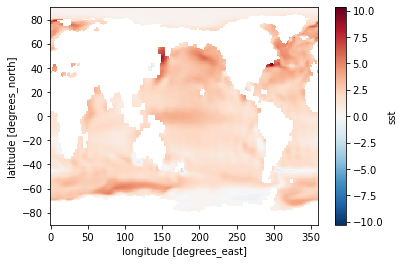

In [22]:
(ds2.sst.mean("time") - ds1.sst.mean("time")).plot()

In [25]:
folder = 'PlioMIP2 data/'
sim1 = 'E280';   filename1_sst = 'E280_sst_monthly.nc'; filename1_slp = 'E280_slp_monthly.nc';
# sim2 = 'Eoi400'; 

i=5
model = modellist[i]

path1 = folder+model+'/'+sim1+'/'+filename1_sst; ds1_sst = xr.open_dataset(path1);
path1 = folder+model+'/'+sim1+'/'+filename1_slp; ds1_slp = xr.open_dataset(path1);
    

In [27]:
sst = ds1_sst.sst
slp = ds1_slp.slp

In [33]:
slp_ = slp.interp_like(sst.isel(time=0))

In [38]:
corrs = xr.corr(sst, slp_, dim="time")

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


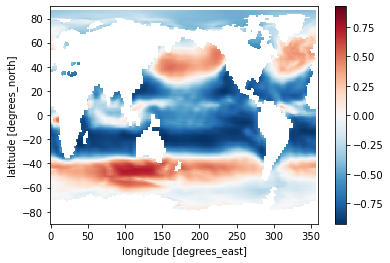

In [39]:
corrs.plot()